# Set of Experiments
Goals: minimizing latency and maximizing benchmark performance, while using lightweight components where possible. 

 

## ⚙️ General Implementation Setup 

Environment: Python 3.10+, TensorFlow/Keras or PyTorch, scikit-learn, HuggingFace Transformers, DeepFace, OpenSMILE, librosa. 

Evaluation Split: Stratified Shuffle Split (70% train, 30% test). 

Metrics Across All Tasks: 
- Accuracy 
- F1-Score (macro): Handles emotion class imbalance. 
- Latency (ms/sample or s/batch) 
- Model Size (MB) 
- Confusion Matrix for qualitative insights. 


 Datasets: RAVDESS, EmoDB, TESS (CREMA-D optional; map to shared label space) 

Labels: Anger, Disgust, Fear, Happiness, Sadness, Surprise, Neutral





Path to dataset files: /Users/sofiafernandes/.cache/kagglehub/datasets/piyushagni5/berlin-database-of-emotional-speech-emodb/versions/1
Path to dataset files: /Users/sofiafernandes/.cache/kagglehub/datasets/uwrfkaggler/ravdess-emotional-speech-audio/versions/1
['Actor_16', 'Actor_11', 'Actor_18', 'Actor_20', 'Actor_21', 'Actor_19', 'Actor_10', 'Actor_17', 'Actor_04', 'Actor_03', 'Actor_02', 'Actor_05', 'audio_speech_actors_01-24', 'Actor_12', 'Actor_15', 'Actor_23', 'Actor_24', 'Actor_22', 'Actor_14', 'Actor_13', 'Actor_09', 'Actor_07', 'Actor_06', 'Actor_01', 'Actor_08']
Path to dataset files: /Users/sofiafernandes/.cache/kagglehub/datasets/ejlok1/toronto-emotional-speech-set-tess/versions/1
['TESS']
['YAF_disgust', 'OAF_Pleasant_surprise', 'OAF_happy', 'YAF_sad', 'YAF_happy', 'YAF_neutral', 'OAF_Fear', 'OAF_angry', 'YAF_pleasant_surprised', 'YAF_fear', 'OAF_neutral', 'OAF_disgust', 'YAF_angry', 'OAF_Sad']


<Axes: title={'center': 'Emotion Distribution'}, xlabel='label'>

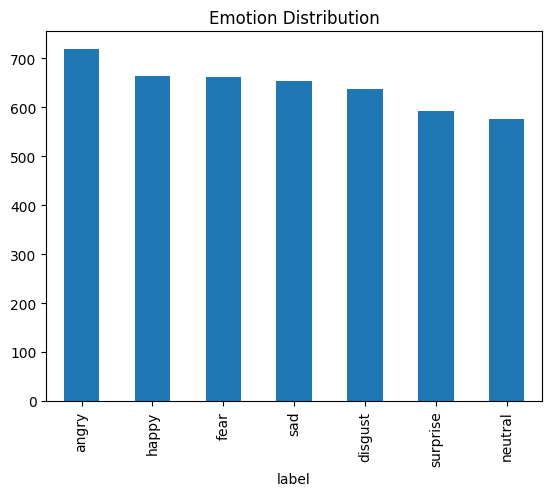

In [54]:
import sys
import os
# insert the path to the source code directory
module_path = os.path.abspath(os.path.join('..', '..')) 
sys.path.insert(0, module_path)

from src.utils import load_emodb, load_ravdess, load_tess, load_crema_d, filter_emotions

import numpy as np
import pandas as pd

emodb = filter_emotions(load_emodb())
ravdess = filter_emotions(load_ravdess())
tess = filter_emotions(load_tess())
#crema = filter_emotions(load_crema_d())

# add a dataset column to each dataset
emodb['dataset'] = 'emodb'
ravdess['dataset'] = 'ravdess'
tess['dataset'] = 'tess'
#crema['dataset'] = 'crema'

# concatenate all datasets
df = pd.concat([emodb, ravdess, tess], ignore_index=True)
# shuffle the dataset
df = df.sample(frac=1, random_state=42).reset_index(drop=True)


# save the dataset to a csv file
output_file = 'combined_emotion_dataset.csv'
df.to_csv(output_file, index=False)

# plot the distribution of emotions
df['label'].value_counts().plot(kind='bar', title='Emotion Distribution')

In [2]:
df.head()

,filename,label,dataset
0,/Users/sofiafernandes/.cache/kagglehub/dataset...,fear,ravdess
1,/Users/sofiafernandes/.cache/kagglehub/dataset...,fear,tess
2,/Users/sofiafernandes/.cache/kagglehub/dataset...,fear,tess
3,/Users/sofiafernandes/.cache/kagglehub/dataset...,fear,tess
4,/Users/sofiafernandes/.cache/kagglehub/dataset...,happy,ravdess


## Extract features with librosa
MFCCs and Pitch

In [8]:
import librosa
from tqdm import tqdm
tqdm.pandas(desc="Processing audio files")

def extract_mfcc_and_pitch(file_path):
    y, sr = librosa.load(file_path, sr=None)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    mel = librosa.feature.melspectrogram(y=y, sr=sr)
    contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    return *mfccs, chroma, mel, contrast

feats_df = df['filename'].progress_apply(extract_mfcc_and_pitch)


Processing audio files: 100%|██████████| 4502/4502 [03:54<00:00, 19.19it/s]


In [39]:
import librosa
import numpy as np

def extract_mfcc_and_chroma(file_path):
    y, sr = librosa.load(file_path, sr=16000)

    # MFCCs
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfcc_mean = np.mean(mfcc, axis=1)
    mfcc_std = np.std(mfcc, axis=1)

    # Chroma
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    chroma_mean = np.mean(chroma, axis=1)
    chroma_std = np.std(chroma, axis=1)

    # Build feature dictionary with names
    features = {}

    for i in range(13):
        features[f'mfcc_{i+1}_mean'] = mfcc_mean[i]
        features[f'mfcc_{i+1}_std'] = mfcc_std[i]
    
    for i in range(12):
        features[f'chroma_{i+1}_mean'] = chroma_mean[i]
        features[f'chroma_{i+1}_std'] = chroma_std[i]

    return features


# Apply to each file
features = df['filename'].progress_apply(extract_mfcc_and_chroma)


Processing audio files: 100%|██████████| 4502/4502 [01:37<00:00, 46.38it/s]


In [44]:
# Convert to DataFrame with named columns
X_df = pd.DataFrame(features.tolist())
X_df

,mfcc_1_mean,mfcc_1_std,mfcc_2_mean,mfcc_2_std,mfcc_3_mean,mfcc_3_std,mfcc_4_mean,mfcc_4_std,mfcc_5_mean,mfcc_5_std,...,chroma_8_mean,chroma_8_std,chroma_9_mean,chroma_9_std,chroma_10_mean,chroma_10_std,chroma_11_mean,chroma_11_std,chroma_12_mean,chroma_12_std
0,-423.737823,155.556229,45.013477,34.249153,-13.370381,20.137459,6.339219,19.328226,1.947282,19.676001,...,0.458617,0.301253,0.494620,0.302833,0.429875,0.282421,0.375186,0.241405,0.374677,0.265290
1,-299.633331,101.864372,7.118066,47.316700,1.094665,39.726635,27.765266,29.232965,-16.163872,33.123688,...,0.283599,0.258683,0.319529,0.275295,0.348262,0.366382,0.303437,0.271256,0.298324,0.321923
2,-439.459778,109.717781,55.487514,55.570675,6.013606,24.976755,-17.582489,34.910042,0.497298,23.781628,...,0.296967,0.330447,0.278803,0.334286,0.301112,0.378007,0.361721,0.382060,0.452278,0.380170
3,-284.457855,101.606804,26.041424,42.850582,-11.973892,37.880882,9.406652,31.843275,-9.789801,25.274546,...,0.443370,0.328631,0.488089,0.366596,0.435272,0.344140,0.376675,0.322523,0.381623,0.366848
4,-568.979248,175.112793,36.469841,53.651775,-5.481939,32.711273,8.402514,24.172672,-6.699379,20.914635,...,0.371972,0.315669,0.278058,0.276136,0.295252,0.313762,0.363050,0.331839,0.396057,0.295708
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4497,-508.948517,71.186592,81.760956,76.236458,23.147593,24.851868,0.195209,28.356699,13.012129,15.423526,...,0.224689,0.319031,0.243182,0.322984,0.345922,0.357529,0.442330,0.411272,0.251875,0.307891
4498,-631.360352,173.709518,42.052280,66.345695,3.912092,35.420006,9.181870,26.812866,-7.202260,21.160345,...,0.377246,0.337412,0.421919,0.377736,0.457387,0.366363,0.391065,0.355625,0.315808,0.326611
4499,-402.525818,102.937057,36.746861,49.176746,2.414918,29.194160,2.531065,37.321991,5.086064,17.951435,...,0.110022,0.193816,0.185230,0.284355,0.242132,0.339403,0.255744,0.345916,0.231770,0.280573
4500,-516.330688,86.486511,74.124962,62.741207,11.925704,25.515640,14.993545,31.846910,16.765678,19.389977,...,0.464844,0.377653,0.177892,0.258702,0.142113,0.264782,0.168064,0.300062,0.184181,0.336469


In [45]:
# Convert list of arrays to 2D numpy array
X = X_df #np.stack(features.values)  # shape: (n_samples, 52)
y = df['label'].values

## 🔊 4.4.1 Speech Emotion Recognition (SER) 

### Experiment 1.1 – SVM Parameter Tuning 

Features: 
- OpenSMILE GeMAPS 
- librosa: MFCCs, chroma, pitch 

Grid Search Params: 

C: [0.1, 1, 10], kernel: [‘linear’, ‘rbf’], gamma: [0.01, 0.1, 1] 

Metrics: Accuracy, F1-macro, Latency (time to predict full test set) 


In [46]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from joblib import dump, load
from sklearn.model_selection import train_test_split

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', SelectKBest(f_classif, k=20)),  # Or whatever method you use
    ('svm', SVC(kernel='linear', C=1.0, probability=True))
])


# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
print(X_train.shape, y_train.shape)
pipeline.fit(X_train, y_train)


(3151, 50) (3151,)


Pipeline(steps=[('scaler', StandardScaler()),
                ('feature_selection', SelectKBest(k=20)),
                ('svm', SVC(kernel='linear', probability=True))])

In [48]:
# perform grid search for hyperparameter tuning
from sklearn.model_selection import GridSearchCV
param_grid = {
    'svm__C': [0.1, 1.0, 10.0],
    'svm__gamma': ['scale', 'auto'],
    'svm__kernel': ['linear', 'rbf'],
    'feature_selection__k': [30, 40, 50] #[10, 20, 30]
}
grid_search = GridSearchCV(pipeline, param_grid, cv=10, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Save the best model
best_model = grid_search.best_estimator_
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)
dump(best_model, 'ser_svm_model.joblib')

Best parameters found:  {'feature_selection__k': 50, 'svm__C': 10.0, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}
Best cross-validation score:  0.8787763713080169


['ser_svm_model.joblib']

Best parameters found:  {'feature_selection__k': 50, 'svm__C': 10.0, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}
Best cross-validation score:  0.8787763713080169

              precision    recall  f1-score   support

       angry       0.87      0.93      0.90       216
     disgust       0.88      0.84      0.86       191
        fear       0.87      0.89      0.88       198
       happy       0.82      0.80      0.81       199
     neutral       0.94      0.92      0.93       173
         sad       0.92      0.93      0.92       196
    surprise       0.88      0.85      0.87       178

    accuracy                           0.88      1351
   macro avg       0.88      0.88      0.88      1351
weighted avg       0.88      0.88      0.88      1351

Accuracy: 0.8815692079940785


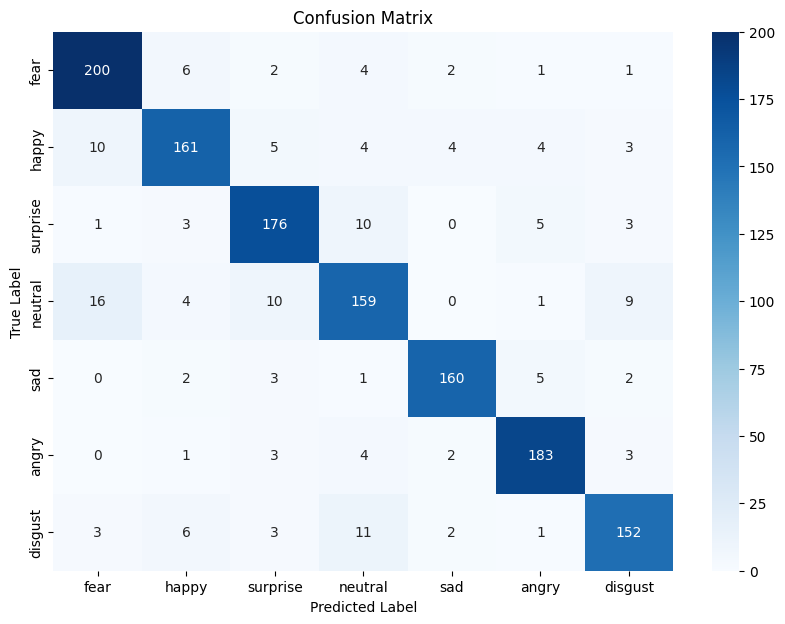

In [49]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from seaborn import heatmap
import matplotlib.pyplot as plt

def evaluate_model(best_model, X_test, y_test):
    """ Evaluate the model on the test set and print the classification report, accuracy, and confusion matrix. """
    # Make predictions
    #y_pred = pipeline.predict(X_test)
    # or using the best model from grid search
    y_pred = best_model.predict(X_test)   
    # Print classification report
    print(classification_report(y_test, y_pred))
    # Print accuracy score
    print("Accuracy:", accuracy_score(y_test, y_pred))

    # Print confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=df['label'].unique(), yticklabels=df['label'].unique())
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

#best_model = pipeline  # or use the best model from grid search
#best_model = load('ser_svm_model.joblib')
evaluate_model(best_model, X_test, y_test)


In [ ]:
import kagglehub
#  Download dataset from Kaggle
path = kagglehub.dataset_download("ejlok1/cremad")
print("Path to dataset files:", path)
# List all files in the dataset
path = path + '/AudioWAV'
crema_directory_list = os.listdir(path)
print(crema_directory_list)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(path + '/' + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('unknown')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['label'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['filename'])
crema_df = pd.concat([emotion_df, path_df], axis=1)
crema_df.head()
print(crema_df.label.value_counts())

Path to dataset files: /Users/sofiafernandes/.cache/kagglehub/datasets/ejlok1/cremad/versions/1
['1022_ITS_ANG_XX.wav', '1037_ITS_ANG_XX.wav', '1060_ITS_NEU_XX.wav', '1075_ITS_NEU_XX.wav', '1073_IOM_DIS_XX.wav', '1066_IOM_DIS_XX.wav', '1078_IWL_SAD_XX.wav', '1029_TAI_FEA_XX.wav', '1039_IEO_SAD_MD.wav', '1008_TAI_HAP_XX.wav', '1018_TSI_FEA_XX.wav', '1028_IEO_SAD_HI.wav', '1039_TSI_HAP_XX.wav', '1064_ITS_HAP_XX.wav', '1071_ITS_HAP_XX.wav', '1045_ITS_FEA_XX.wav', '1050_ITS_FEA_XX.wav', '1018_IWL_ANG_XX.wav', '1059_IEO_ANG_MD.wav', '1054_MTI_DIS_XX.wav', '1041_MTI_DIS_XX.wav', '1048_IEO_ANG_HI.wav', '1042_ITS_SAD_XX.wav', '1019_TAI_NEU_XX.wav', '1057_ITS_SAD_XX.wav', '1028_TSI_NEU_XX.wav', '1087_IOM_ANG_XX.wav', '1039_IEO_HAP_LO.wav', '1018_IEO_FEA_LO.wav', '1079_DFA_NEU_XX.wav', '1063_IWW_DIS_XX.wav', '1076_IWW_DIS_XX.wav', '1068_WSI_HAP_XX.wav', '1049_WSI_FEA_XX.wav', '1059_ITH_DIS_XX.wav', '1068_DFA_HAP_XX.wav', '1049_DFA_FEA_XX.wav', '1079_WSI_NEU_XX.wav', '1082_IWW_ANG_XX.wav', '1061_

Processing audio files:  62%|██████▏   | 4649/7442 [01:28<00:46, 59.84it/s]/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
Processing audio files: 100%|██████████| 7442/7442 [02:18<00:00, 53.87it/s]


              precision    recall  f1-score   support

       angry       0.89      0.03      0.06      1271
     disgust       0.08      0.00      0.01      1271
        fear       0.19      0.20      0.19      1271
       happy       0.21      0.02      0.04      1271
     neutral       0.11      0.07      0.09      1087
         sad       0.23      0.96      0.37      1271

    accuracy                           0.22      7442
   macro avg       0.29      0.21      0.13      7442
weighted avg       0.29      0.22      0.13      7442

Accuracy: 0.21741467347487234


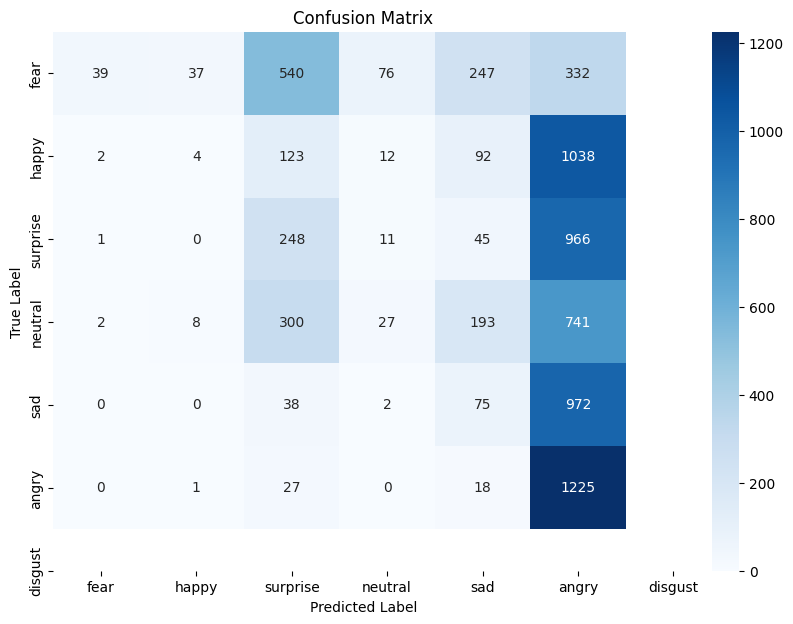

In [ ]:
crema_feats = crema_df['filename'].progress_apply(extract_mfcc_and_chroma)
X_crema = pd.DataFrame(crema_feats.tolist())
y_crema = crema_df['label'].values
# test the model on the CREMA-D dataset
evaluate_model(best_model, X_crema, y_crema)

(10039, 62)


/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


              precision    recall  f1-score   support

       angry       0.86      0.17      0.28      1269
     disgust       0.00      0.00      0.00         2
        fear       0.03      0.19      0.05       107
       happy       0.14      0.33      0.20       656
     neutral       0.42      0.12      0.18      1726
         sad       0.44      0.40      0.42      1250
    surprise       0.07      0.28      0.12       110

    accuracy                           0.23      5120
   macro avg       0.28      0.21      0.18      5120
weighted avg       0.48      0.23      0.26      5120

Accuracy: 0.2298828125


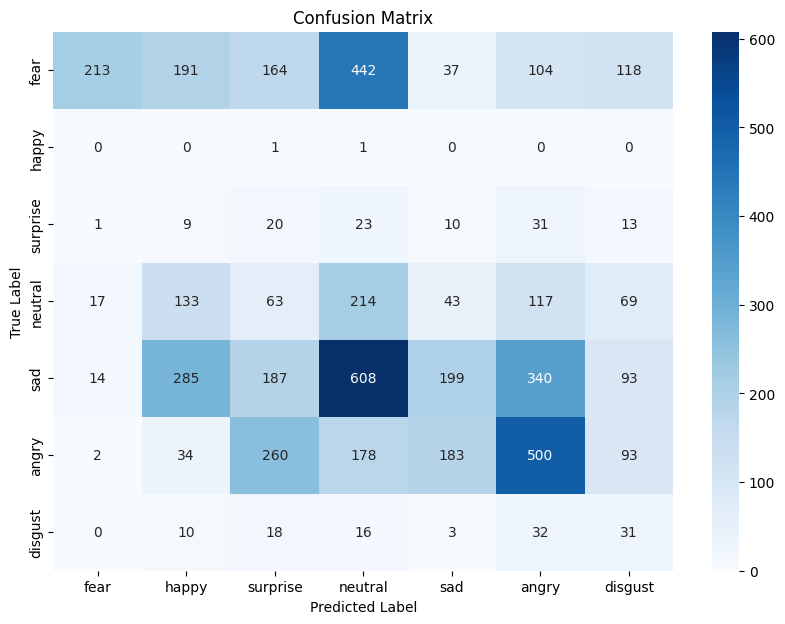

In [107]:
# Load features from disk
data = np.load('./features/iemocap_GeMAPS_features.npz')
print(data['X'].shape)  # Check available arrays in the file
X = data['X']
y = data['y']
# filter bothe to only include allowed emotions
allowed_emotions = ['happy', 'sad', 'angry', 'neutral', 'fear', 'surprise', 'disgust']
mask = np.isin(y, allowed_emotions)
X = X[mask]
y = y[mask]

evaluate_model(best_model, X, y)



In [111]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# perform grid search for hyperparameter tuning
from sklearn.model_selection import GridSearchCV
param_grid = {
    'svm__C': [0.1, 1.0, 10.0],
    'svm__gamma': ['scale', 'auto'],
    'svm__kernel': ['rbf', 'linear'], #['linear', 'rbf'],
    'feature_selection__k': [20, 30, 40] #[10, 20, 30]
}
grid_search = GridSearchCV(pipeline, param_grid, cv=10, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Save the best model
best_model = grid_search.best_estimator_
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)
dump(best_model, 'ser_svm_model_iemocap.joblib')

/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(


Best parameters found:  {'feature_selection__k': 40, 'svm__C': 1.0, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}
Best cross-validation score:  0.5931918270801886


['ser_svm_model_iemocap.joblib']

In [51]:
## EMO-DB dataset evaluation
emodb = df[df['dataset'] == 'emodb']
# collect idx of the EMO-DB dataset in the combined features dataframe
emodb_idx = [idx for idx in emodb.index]# if idx in y_test.index]
print(emodb_idx)
feats_emodb = feats_df.iloc[emodb_idx]
emodb_test = df.iloc[emodb_idx]
# Save the features to a csv file
feats_emodb.to_csv('emodb_test_features_librosa.csv', index=False)

X1 = feats_emodb
y1 = emodb_test['label']
# Split the dataset into training and testing sets
#X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.3, random_state=42, stratify=y1)
# Make predictions
evaluate_model(best_model, X1, y1)

[7, 10, 40, 41, 55, 56, 57, 64, 67, 69, 77, 81, 131, 138, 143, 144, 148, 154, 157, 162, 168, 190, 213, 225, 229, 233, 245, 261, 262, 263, 266, 276, 280, 301, 314, 317, 330, 334, 342, 347, 350, 362, 363, 386, 393, 396, 404, 409, 417, 429, 443, 452, 465, 466, 475, 476, 487, 501, 513, 514, 515, 517, 519, 526, 528, 537, 539, 545, 548, 549, 551, 557, 559, 579, 582, 587, 605, 614, 630, 633, 655, 668, 688, 693, 699, 726, 741, 769, 774, 786, 810, 814, 815, 836, 846, 855, 872, 876, 889, 911, 912, 916, 921, 948, 960, 962, 966, 974, 977, 989, 996, 1006, 1007, 1012, 1017, 1018, 1021, 1033, 1035, 1041, 1050, 1063, 1065, 1076, 1118, 1119, 1121, 1131, 1143, 1145, 1162, 1165, 1166, 1168, 1182, 1189, 1195, 1207, 1209, 1222, 1232, 1238, 1241, 1242, 1254, 1264, 1272, 1280, 1302, 1336, 1346, 1353, 1357, 1359, 1360, 1390, 1392, 1397, 1409, 1421, 1431, 1444, 1448, 1468, 1474, 1489, 1502, 1534, 1540, 1554, 1563, 1568, 1570, 1591, 1599, 1610, 1628, 1631, 1633, 1640, 1663, 1665, 1673, 1685, 1687, 1698, 1703, 1

/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


ValueError: setting an array element with a sequence.

[0, 4, 14, 16, 18, 25, 29, 32, 44, 45, 48, 49, 54, 60, 62, 66, 73, 75, 82, 83, 85, 90, 93, 94, 95, 100, 108, 112, 113, 120, 124, 125, 130, 132, 136, 146, 151, 152, 158, 160, 161, 164, 172, 174, 175, 177, 178, 182, 183, 187, 188, 191, 193, 201, 205, 207, 210, 211, 212, 215, 217, 218, 219, 228, 239, 250, 251, 254, 259, 271, 272, 275, 282, 286, 288, 290, 292, 293, 300, 302, 304, 306, 307, 308, 309, 311, 319, 320, 321, 322, 323, 328, 333, 338, 340, 343, 344, 359, 361, 364, 367, 368, 369, 370, 375, 379, 383, 389, 391, 394, 397, 398, 400, 402, 405, 411, 413, 418, 419, 426, 428, 430, 431, 438, 442, 445, 446, 450, 453, 454, 455, 458, 460, 461, 470, 471, 473, 484, 486, 488, 490, 493, 500, 503, 507, 512, 516, 518, 520, 529, 530, 536, 540, 563, 564, 566, 567, 568, 570, 571, 572, 576, 581, 584, 586, 599, 602, 608, 612, 616, 617, 619, 620, 625, 628, 631, 632, 638, 639, 640, 641, 646, 647, 650, 657, 658, 660, 671, 675, 676, 678, 681, 682, 683, 684, 685, 686, 690, 697, 698, 706, 707, 711, 712, 714, 7

/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: Undefin

              precision    recall  f1-score   support

       angry       0.17      0.99      0.29       192
     disgust       0.00      0.00      0.00       192
        fear       0.00      0.00      0.00       192
       happy       0.00      0.00      0.00       192
     neutral       0.23      0.28      0.26        96
         sad       1.00      0.01      0.01       192
    surprise       0.00      0.00      0.00       192

    accuracy                           0.18      1248
   macro avg       0.20      0.18      0.08      1248
weighted avg       0.20      0.18      0.07      1248

Accuracy: 0.17548076923076922


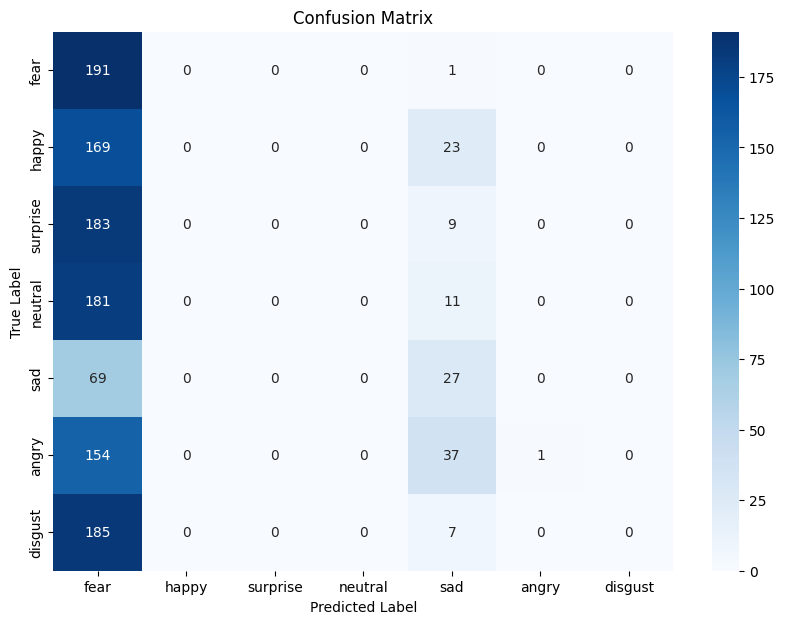

In [ ]:
## RAVDESS dataset evaluation
ravdess = df[df['dataset'] == 'ravdess']
# collect idx of the RAVDESS dataset in the combined features dataframe
ravdess_idx = [idx for idx in ravdess.index]# if idx in y_test.index]
print(ravdess_idx)
feats_ravdess = feats_df.iloc[ravdess_idx]
ravdess_test = df.iloc[ravdess_idx]
# Save the features to a csv file
feats_ravdess.to_csv('ravdess_test_features.csv', index=False)  
X2 = feats_ravdess
y2 = ravdess_test['label']
# Make predictions
evaluate_model(best_model, X2, y2)

In [52]:
## TESS dataset evaluation
tess = df[df['dataset'] == 'tess']
# collect idx of the TESS dataset in the combined features dataframe
tess_idx = [idx for idx in tess.index]# if idx in y_test.index]
print(tess_idx)
feats_tess = feats_df.iloc[tess_idx]
tess_test = df.iloc[tess_idx]
# Save the features to a csv file
feats_tess.to_csv('tess_test_features.csv', index=False)
X3 = feats_tess
y3 = tess_test['label']
# Make predictions
evaluate_model(best_model, X3, y3)

[1, 2, 3, 5, 6, 8, 9, 11, 12, 13, 15, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28, 30, 31, 33, 34, 35, 36, 37, 38, 39, 42, 43, 46, 47, 50, 51, 52, 53, 58, 59, 61, 63, 65, 68, 70, 71, 72, 74, 76, 78, 79, 80, 84, 86, 87, 88, 89, 91, 92, 96, 97, 98, 99, 101, 102, 103, 104, 105, 106, 107, 109, 110, 111, 114, 115, 116, 117, 118, 119, 121, 122, 123, 126, 127, 128, 129, 133, 134, 135, 137, 139, 140, 141, 142, 145, 147, 149, 150, 153, 155, 156, 159, 163, 165, 166, 167, 169, 170, 171, 173, 176, 179, 180, 181, 184, 185, 186, 189, 192, 194, 195, 196, 197, 198, 199, 200, 202, 203, 204, 206, 208, 209, 214, 216, 220, 221, 222, 223, 224, 226, 227, 230, 231, 232, 234, 235, 236, 237, 238, 240, 241, 242, 243, 244, 246, 247, 248, 249, 252, 253, 255, 256, 257, 258, 260, 264, 265, 267, 268, 269, 270, 273, 274, 277, 278, 279, 281, 283, 284, 285, 287, 289, 291, 294, 295, 296, 297, 298, 299, 303, 305, 310, 312, 313, 315, 316, 318, 324, 325, 326, 327, 329, 331, 332, 335, 336, 337, 339, 341, 345, 346, 348, 349, 351,

/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


ValueError: setting an array element with a sequence.

### Experiment 1.2 – LSTM vs CNN 

Architecture: 

CNN: 1D Conv + GlobalMaxPooling 

LSTM: 1–2 stacked LSTM layers 

Input: Normalized MFCCs (fixed-length padded sequences) 

Metrics: F1-macro, Model size, Inference latency 

Write: We started to build a small CNN with only one layer of convolution, but it was too shallow to learn the characteristics extracted with openSMILE, so we started adding layers and reducing dropout until we started to get reasonable results.


In [55]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, GlobalMaxPooling1D, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# CNN: 1D + GlobalMaxPooling1D
# Define the model
def create_cnn_model(input_shape, num_classes):
    
    model = Sequential()
    
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(Dropout(0.1))

    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(Dropout(0.1))

    model.add(GlobalMaxPooling1D())
    
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.1))

    model.add(Dense(num_classes, activation='softmax'))

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0003)  # menor lr para mais estabilidade
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model
# Train on X_train, y_train
cnn_model = create_cnn_model((X_train.shape[1], 1), len(df['label'].unique()))
# add early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
# add a callback to save the best model
checkpoint = tf.keras.callbacks.ModelCheckpoint('ser_cnn_model.h5', monitor='val_loss', save_best_only=True, mode='min')
# add the checkpoint to the callbacks
callbacks = [early_stopping, checkpoint]
# learning rate scheduler
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3 * 0.9 ** epoch, verbose=1)
callbacks.append(lr_scheduler)
# define learning rate as constant
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_reshaped = X_train_scaled.reshape(-1, X_train.shape[1], 1)
X_test_reshaped = X_test_scaled.reshape(-1, X_test.shape[1], 1)
# train the CNN model
cnn_model.fit(X_train_reshaped, y_train_encoded, epochs=1000, batch_size=16, validation_split=0.2, callbacks=callbacks)


2025-07-15 14:50:55.913661: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.



Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/1000
158/158 [==============================] - 3s 9ms/step - loss: 1.8613 - accuracy: 0.3242 - val_loss: 1.7975 - val_accuracy: 0.4295 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009000000000000001.
Epoch 2/1000
 17/158 [==>...........................] - ETA: 0s - loss: 1.6010 - accuracy: 0.3897

/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


158/158 [==============================] - 1s 7ms/step - loss: 1.5464 - accuracy: 0.4127 - val_loss: 1.5808 - val_accuracy: 0.5071 - lr: 9.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0008100000000000001.
Epoch 3/1000
158/158 [==============================] - 1s 7ms/step - loss: 1.4587 - accuracy: 0.4607 - val_loss: 1.3673 - val_accuracy: 0.5499 - lr: 8.1000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0007290000000000002.
Epoch 4/1000
158/158 [==============================] - 1s 7ms/step - loss: 1.3797 - accuracy: 0.4929 - val_loss: 1.2545 - val_accuracy: 0.5689 - lr: 7.2900e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0006561000000000001.
Epoch 5/1000
158/158 [==============================] - 1s 9ms/step - loss: 1.3231 - accuracy: 0.5087 - val_loss: 1.2026 - val_accuracy: 0.5832 - lr: 6.5610e-04

Epoch 6: LearningRateScheduler setting learning rate to 0.00059049.
Epoch 6/1000
158/158 [==============================] - 1s 7

In [56]:
# Evaluate the CNN model
cnn_loss, cnn_accuracy = cnn_model.evaluate(X_test_reshaped, y_test_encoded)
print(f"CNN Test Loss: {cnn_loss}, Test Accuracy: {cnn_accuracy}")
# Save the CNN model
cnn_model.save('ser_cnn_model.h5')
# Save end to end model (with feature extraction, scaler, and CNN)
import joblib
end_to_end_model = {
    #'feature_extractor': ext,
    'scaler': scaler,
    'cnn_model': cnn_model,
    'label_encoder': le
}
joblib.dump(end_to_end_model, 'ser_end_to_end_model.joblib')


43/43 [==============================] - 0s 3ms/step - loss: 0.9478 - accuracy: 0.6543
CNN Test Loss: 0.9477793574333191, Test Accuracy: 0.6543301343917847


/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


['ser_end_to_end_model.joblib']

In [57]:

X1_test_scaled = scaler.transform(X1)
X1_test_reshaped = X1_test_scaled.reshape(-1, X1.shape[1], 1)
y1 = le.transform(y1)  # Encode labels for EMO-DB
X2_test_scaled = scaler.transform(X2)
X2_test_reshaped = X2_test_scaled.reshape(-1, X2.shape[1], 1)
y2 = le.transform(y2)  # Encode labels for RAVDESS
X3_test_scaled = scaler.transform(X3)
X3_test_reshaped = X3_test_scaled.reshape(-1, X3.shape[1], 1)
y3 = le.transform(y3)  # Encode labels for TESS

/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


ValueError: setting an array element with a sequence.

In [58]:

# Evaluate the CNN model on EMO-DB dataset
cnn_emodb_loss, cnn_emodb_accuracy = cnn_model.evaluate(feats_emodb.values.reshape(feats_emodb.shape[0], feats_emodb.shape[1], 1), y1)
print(f"CNN EMO-DB Test Loss: {cnn_emodb_loss}, Test Accuracy: {cnn_emodb_accuracy}")
# Evaluate the CNN model on RAVDESS dataset
cnn_ravdess_loss, cnn_ravdess_accuracy = cnn_model.evaluate(feats_ravdess.values.reshape(feats_ravdess.shape[0], feats_ravdess.shape[1], 1), y2)
print(f"CNN RAVDESS Test Loss: {cnn_ravdess_loss}, Test Accuracy: {cnn_ravdess_accuracy}")
# Evaluate the CNN model on TESS dataset
cnn_tess_loss, cnn_tess_accuracy = cnn_model.evaluate(feats_tess.values.reshape(feats_tess.shape[0], feats_tess.shape[1], 1), y3)
print(f"CNN TESS Test Loss: {cnn_tess_loss}, Test Accuracy: {cnn_tess_accuracy}")

IndexError: tuple index out of range

CNN + LSTM

- Short-term GeMAPS (LLDs only)
- Fixed-length padding/truncation
- CNN input-ready formatting
- Feature scaling (per-feature)

In [59]:
from tensorflow.keras.layers import LSTM, TimeDistributed, BatchNormalization

def create_cnn_lstm_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer=tf.keras.optimizers.Adam(0.0003), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Train on X_train, y_train
cnn_model = create_cnn_lstm_model((X_train.shape[1], 1), len(df['label'].unique()))
# add early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
# add a callback to save the best model
checkpoint = tf.keras.callbacks.ModelCheckpoint('ser_cnn_model.h5', monitor='val_loss', save_best_only=True, mode='min')
# add the checkpoint to the callbacks
callbacks = [early_stopping, checkpoint]
# learning rate scheduler
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3 * 0.9 ** epoch, verbose=1)
callbacks.append(lr_scheduler)
# define learning rate as constant
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_reshaped = X_train_scaled.reshape(-1, X_train.shape[1], 1)
X_test_reshaped = X_test_scaled.reshape(-1, X_test.shape[1], 1)
# train the CNN model
cnn_model.fit(X_train_reshaped, y_train_encoded, epochs=1000, batch_size=16, validation_split=0.2, callbacks=callbacks)


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/1000
158/158 [==============================] - 8s 24ms/step - loss: 1.7402 - accuracy: 0.3036 - val_loss: 1.9053 - val_accuracy: 0.1933 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009000000000000001.
Epoch 2/1000
  7/158 [>.............................] - ETA: 3s - loss: 1.6400 - accuracy: 0.3482

/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


158/158 [==============================] - 3s 22ms/step - loss: 1.5220 - accuracy: 0.4099 - val_loss: 1.8362 - val_accuracy: 0.2694 - lr: 9.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0008100000000000001.
Epoch 3/1000
158/158 [==============================] - 3s 21ms/step - loss: 1.4215 - accuracy: 0.4464 - val_loss: 1.4229 - val_accuracy: 0.4453 - lr: 8.1000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0007290000000000002.
Epoch 4/1000
158/158 [==============================] - 3s 22ms/step - loss: 1.3411 - accuracy: 0.4841 - val_loss: 1.3164 - val_accuracy: 0.4913 - lr: 7.2900e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0006561000000000001.
Epoch 5/1000
158/158 [==============================] - 3s 20ms/step - loss: 1.3102 - accuracy: 0.4996 - val_loss: 1.2623 - val_accuracy: 0.5246 - lr: 6.5610e-04

Epoch 6: LearningRateScheduler setting learning rate to 0.00059049.
Epoch 6/1000
158/158 [==============================] - 

In [60]:
import numpy as np

def pad_or_truncate(features, max_frames=200):
    num_frames, num_features = features.shape
    if num_frames >= max_frames:
        return features[:max_frames, :]
    else:
        padding = np.zeros((max_frames - num_frames, num_features))
        return np.vstack((features, padding))


from sklearn.preprocessing import StandardScaler

def standardize_features(X):
    num_samples, num_frames, num_features = X.shape
    X_reshaped = X.reshape(-1, num_features)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_reshaped)
    return X_scaled.reshape(num_samples, num_frames, num_features), scaler


from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(y)

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, Dropout, GlobalMaxPooling1D, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

def create_cnn_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv1D(64, 3, activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Conv1D(128, 3, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(GlobalMaxPooling1D())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer=tf.keras.optimizers.Adam(0.0003),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model


callbacks = [
    EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True),
    ModelCheckpoint('cnn_gemaps_model.h5', monitor='val_loss', save_best_only=True)
]
max_frames = 2000
num_features = feats_df.shape[1]
#X_train_padded = np.array([pad_or_truncate(feats) for feats in feats_df.values])
X_train_scaled = scaler.transform(X_train)
X_train_reshaped = X_train_scaled.reshape(-1, max_frames, num_features)
cnn_model = create_cnn_model(input_shape=(max_frames, num_features), num_classes=len(np.unique(y_encoded)))
cnn_model.fit(X_train, y_train_encoded, epochs=200, batch_size=16,
              validation_split=0.2, callbacks=callbacks)

# Evaluate the CNN model
cnn_loss, cnn_accuracy = cnn_model.evaluate(X_test, y_test_encoded)
print(f"CNN Test Loss: {cnn_loss}, Test Accuracy: {cnn_accuracy}")

IndexError: tuple index out of range

### Experiment 1.3 – Apply SOTA or hybrid 

Reference Methods: Implement or replicate: 

[Zhao et al., 2019] CNN+Attention 

[Neumann & Vu, 2020] BiLSTM + Attention 

Compare to baseline: SVM + GeMAPS 

Dataset Augmentation: Try data balancing (SMOTE or oversampling) 